##Install Modules

In [ ]:
!pip install lenstronomy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.9-py3-none-any.whl size=1358659 sha256=182e6d5a97f44c370509405df901aee129e5c59e6d9f7bec320252c081cf4527
  Stored in directory: /root/.cache/pip/wheels/6c/4c/bf/e73c7e5a4b5568e1028738aae7eee24dc2efe5926a8e8a0252
Successfully built lenstronomy


In [ ]:
import numpy as np
import scipy
import os
import cv2
import json
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.SimulationAPI import model_api, data_api
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import os
from PIL import Image as im
from astropy.io import fits



##Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Define Functions

In [ ]:
# Function for simulating main lens
def MainLens(theta_E, e1, e2, center_x, center_y):
    # Specify the choice of lens models (Singular Isothermal Ellipsoid in this case)#
    lens_model_list = ['SIE']

    # Setup lens model class with the list of lens models #
    lensModel = LensModel(lens_model_list=lens_model_list)

    # Define parameter values of lens models #
    kwargs_spep = {'theta_E': theta_E, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}
    kwargs_lens = [kwargs_spep]

    # Create lens model class
    lensModel = LensModel(lens_model_list)

    # Calculate convergence map
    x_grid, y_grid = util.make_grid(numPix=img_dim, deltapix=deltaPix)
    kappa_lens = lensModel.kappa(x_grid, y_grid, kwargs_lens)

    # Make an image from the array
    convergence = util.array2image(kappa_lens)

    return lensModel, lens_model_list, kwargs_lens, convergence



# Function for simulating the source light
def SourceLight(amp,R_sersic, n_sersic, e1, e2, center_x, center_y ):
    # Define the model used
    source_light_model_list = ['SERSIC_ELLIPSE']

    # Create source light class
    lightModel_source = LightModel(light_model_list=source_light_model_list)

    # Define the parameters
    kwargs_light_source = [{'amp': amp, 'R_sersic': R_sersic, 'n_sersic': n_sersic, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}]

    return lightModel_source, kwargs_light_source, source_light_model_list



# Define function for adding subhalos to the main lens. Needs to be seperate as the gravitational lens needs to be simulated
# to calculate the bright pixels
def add_subhalos(theta_E, locations, lens_model_list, lensModel, num_subhalos, kwargs_lens, mass_bin, concentration):
  # Define subhalo model and the cosmology used
  subhalo_type = 'TNFW'
  cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)
  lens_cosmo = LensCosmo(z_lens=0.2, z_source=1.5, cosmo=cosmo)

  # Create list of subhalo masses from mass_bin list
  mass_list=[]
  for m in mass_bin:
    a = m - 0.25
    b = m + 0.25
    mass = loguniform.rvs(10**(a), 10**(b), size=num_subhalos) # draw a mass from the bin from a log distribution
    mass_list.extend(mass)

  # Turn mass list into array
  mass_list = np.array(mass_list)

  # Randomly select the location of the subhalo from the bright pixels
  rand_loc = np.random.permutation(locations) # get a random bright pixel location

  # Convert pixel coordinate to angular coordinate
  center_x_list = (rand_loc[0:num_subhalos*len(mass_bin), 1] - (img_dim/2))/(img_dim/5)
  center_y_list = (rand_loc[0:num_subhalos*len(mass_bin), 0] - (img_dim/2))/(img_dim/5)

  # Append each subhalo accordingly to the lens model list and kwargs
  for i in range(num_subhalos*len(mass_bin)):
      lens_model_list.append(subhalo_type)

      # Convert the mass and concentration to deflection angle parameters required by the function
      alpha_Rs_list, Rs_list = lens_cosmo.nfw_physical2angle(M=mass_list, c=concentration)
      kwargs_lens.append({'alpha_Rs': alpha_Rs_list[i], 'Rs': Rs_list[i],
                                'center_x': center_x_list[i], 'center_y': center_y_list[i],
                              'r_trunc': 5*Rs_list[i]
                              })

  return  kwargs_lens,center_x_list, center_y_list,lens_model_list


# Function for making subhalo mask
def subhalo_mask():
  # Calculate the number of mass bins as each needs its own mass bin
  channel = len(mass_bin)+1

  # Initialise the masks
  all_masks = np.zeros((img_dim, img_dim, channel))
  image_shape=(img_dim, img_dim)

  # Convert angular coordinates to pixel coordinates
  x, y = pixel_grid.map_coord2pix(center_x_list, center_y_list )
  radius = 2

  # Run through each subhalo in the mass bin
  for i in range(len(center_x_list)):
    # Define center
    center = (int(x[i]),int(y[i]))
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    rows, cols = np.ogrid[:image_shape[0], :image_shape[1]]

    # Calculate distance from the center of the subhalo and set any pixels inside the radius to 1
    distance_map = np.sqrt((rows - center[0])**2 + (cols - center[1])**2)
    mask[distance_map <= radius] = 1
    mask = np.transpose(mask)

    # Assign this mask to the corresponding mass bin channel and the background mask
    all_masks[:, :, i]=mask
    all_masks[:,:,-1]+=mask

  # Invert the background mask after adding all subhalos from all mass bins
  all_masks[:,:,-1] = (all_masks[:,:,-1] == 0)

  return all_masks

## Generate Images

In [ ]:
# Overall number of images for all datasets
n=1

# Image dimensions (square)
img_dim = 80

# The mass bins wanting to be included
mass_bin = [9,10]

# Define the apparent magnitude of the light source
app_mag = 17

# Run through each image wanted
for i in range(n):

    # Define the parameters of the lens
    # Einstein radius
    theta_E = 1

    # Ellipticity
    q_lens = 1

    # Angle of major axis (radian)
    phi = 0.8 # major axis direction from E to N
    e1_lens, e2_lens = param_util.phi_q2_ellipticity(phi=phi, q=q_lens)

    # Center of main lens
    center_x_lens = 0
    center_y_lens = 0

    # Number of subhalos per mass bin
    num_subhalos = 1

    # Define parameters for the light source
    # Radius
    R_sersic = 0.1

    # Curvature
    n_sersic = 0.5

    # Ratio of the minor-to-major axes of the ellipse
    q_source = 0.5

    # Orientation
    phi = 0
    e1_source, e2_source =  param_util.phi_q2_ellipticity(phi=phi, q=q_source)

    # Define the amplitude based on the zero-point and the apparent magnitude
    zero_point = 25.96
    amp = (10**((app_mag-zero_point)/-2.5))/2

    # Center of the light source
    center_x_source = 0
    center_y_source = 0

    # Size of pixel in angular coordinates
    deltaPix = 0.05

    # Define main lens and source light classes
    lensModel, lens_model_list, kwargs_lens, convergence = MainLens(theta_E, e1_lens, e2_lens, center_x_lens, center_y_lens)
    lightModel_source, kwargs_light_source, source_light_model_list = SourceLight(amp, R_sersic, n_sersic, e1_source, e2_source, center_x_source, center_y_source)

    # Define kwargs for the simulation kwargs
    ra_at_xy_0, dec_at_xy_0 = -2, -2 # Coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # Linear translation matrix of a shift in pixel in a shift in coordinates
    kwargs_pixel = {'nx': img_dim, 'ny': img_dim,  # Number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                    'transform_pix2angle': transform_pix2angle}


    # Define kwargs for the point spread function
    kwargs_psf = {'psf_type': 'PIXEL',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
                  'fwhm': 0.08,  # full width at half maximum of the Gaussian PSF (in angular units)
                  'pixel_size': deltaPix,  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
                }

    # Open Tiny Time PSF kernel
    with fits.open('/content/drive/MyDrive/psf_kernel.fits') as f:
        psf_kernel = f[0].data

    # Remove pixels near edges that display artifacts (resized from 99x99 to 81x81 - needs to be odd-shaped)
    psf_kernel = psf_kernel[9:-9, 9:-9]
    # Normalises the image
    psf_kernel /= psf_kernel.sum()
    psf_kernel = psf_kernel.astype(float)

    # Define simulation kwargs
    kwargs_simulation = {
            # Instrument-related
            'read_noise': 3,  # Std of noise generated by read-out (in units of electrons)
            'ccd_gain': 2.5,  # Electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
            'pixel_scale': deltaPix,  # Scale (in arcseonds) of pixels

            # Observation-related
            'sky_brightness': 22.3,  # Sky brightness (in magnitude per square arcseconds)
            'exposure_time': 3300,  # Exposure time per image (in seconds)
            'magnitude_zero_point': zero_point,  # Magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
            'num_exposures': 4,  # Number of exposures that are combined
            'data_count_unit': 'e-',  # 'ADU' or 'e-'
            'background_noise': 0.05, # In units of data_count_unit

            'kwargs_pixel_grid':kwargs_pixel,
            'psf_type': 'PIXEL',  # String, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
            'kernel_point_source': psf_kernel  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
        }

    # Can add lens light using "'lens_light_model_list': ['SERSIC_ELLIPSE']," or point source model using "'point_source_model_list': ['SOURCE_POSITION']"
    kwargs_model = {"lens_model_list": lens_model_list,
                    "source_light_model_list": source_light_model_list}

    # Simulate the gravitational lens
    simModel = SimAPI(numpix=img_dim, kwargs_single_band=kwargs_simulation, kwargs_model=kwargs_model)


    # Define the numerics
    kwargs_numerics = {'supersampling_factor': 5} # each pixel gets super-sampled (in each axis direction)

    # Create image model class from the simulation
    imageModel = simModel.image_model_class(kwargs_numerics)

    # Simulate image with the parameters defined above
    image_no_noise = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, kwargs_ps=kwargs_psf)

    if num_subhalos != 0:
        # Threshold image with bright pixels
        threshold = 0.5 * np.max(image_no_noise)

        # Create a mask where bright pixel condition is true
        mask = np.where(image_no_noise >= threshold, 1, 0)

        # Create list of indexes where the bright pixel condition is met
        locations = np.argwhere(mask)

        # Define concentrations
        concentration = 15

        # Appened subhalos to convergence
        kwargs_lens,center_x_list, center_y_list,lens_model_list = add_subhalos(theta_E, locations, lens_model_list, lensModel, num_subhalos, kwargs_lens, mass_bin, concentration)

        # Redefine model kwargs now subhalos have been added
        kwargs_model = {"lens_model_list": lens_model_list,
                    "source_light_model_list": source_light_model_list}

        # Repeat simulation and image generation from above
        simModel = SimAPI(numpix=img_dim, kwargs_single_band=kwargs_simulation, kwargs_model=kwargs_model)
        imageModel = simModel.image_model_class(kwargs_numerics)
        image_no_noise = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, kwargs_ps=kwargs_psf)

    # Add noise
    image = image_no_noise + simModel.noise_for_model(model=image_no_noise)

    # Make masks for each image
    masks= subhalo_mask()

    # Save masks and images to dir
    dir = f'/content/drive/MyDrive/Project Colab Notebooks/multisubhalos_diffmasses'
    os.chdir(dir)

    hdu_image = fits.PrimaryHDU(image)
    hdul_image = fits.HDUList([hdu_image])
    header = hdul_image[0].header #creates header
    header['SUBHALOS'] = num_subhalos
    hdul_image.writeto(f"image/subhalo_{i}.fits", overwrite=True)

    hdu = fits.PrimaryHDU(masks)
    hdul_mask = fits.HDUList([hdu])
    hdul_mask.writeto(f"mask/mask_{i}.fits", overwrite=True)



0


'\n    dir = f\'/content/drive/MyDrive/Project Colab Notebooks/multisubhalos_diffmasses\'\n    os.chdir(dir)\n\n    hdu_image = fits.PrimaryHDU(image)\n    hdul_image = fits.HDUList([hdu_image])\n    header = hdul_image[0].header #creates header\n    header[\'SUBHALOS\'] = num_subhalos\n    hdul_image.writeto(f"image/subhalo_{i}.fits", overwrite=True)\n\n    hdu = fits.PrimaryHDU(masks)\n    hdul_mask = fits.HDUList([hdu])\n    hdul_mask.writeto(f"mask/mask_{i}.fits", overwrite=True)\n'

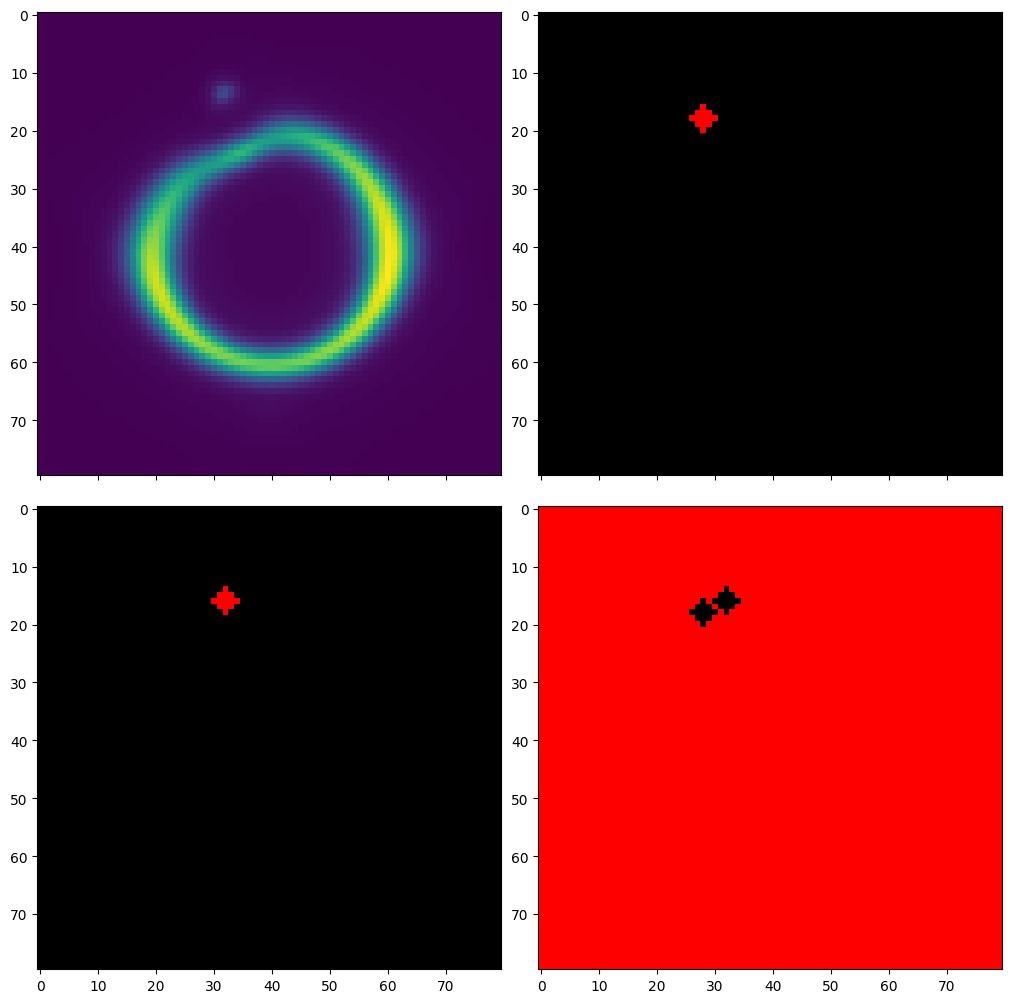

In [ ]:
#check that masks were made correctly
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['black', 'red', 'purple']
custom_cmap = ListedColormap(colors)
bounds = [0, 1, 2,3]
norm = BoundaryNorm(bounds, custom_cmap.N)
fig, ax = plt.subplots(2,2, figsize=(10,10),  sharex=True, layout='constrained')
ax[0,0].imshow(image )
ax[0,1].imshow(masks[:,:,0], cmap=custom_cmap, norm=norm)
ax2 = ax[1,0].imshow(masks[:,:,1],cmap=custom_cmap, norm=norm)
ax[1,1].imshow(masks[:,:,2], cmap=custom_cmap, norm=norm)
